# 计算机视觉纳米学位项目

## 实战项目：图像标注

---

Microsoft **C**ommon **O**bjects in **CO**ntext (MS COCO)  数据集是用于场景理解的一个大型数据集。 该数据集通常用于训练并对目标检测进行基准测试、分割和标注生成算法。

![Sample Dog Output](https://raw.githubusercontent.com/rawk-v/MLND-projects/master/cv-project1-image-caption/images/coco-examples.jpg)

你可以在 [该网站](http://cocodataset.org/#home) 或在 [该研究论文](https://arxiv.org/pdf/1405.0312.pdf)中查阅有关该数据集的更多信息。

在这个 notebook 中，你将要对此数据集进行研究，从而为该实战项目做准备。

## Step 1: 初始化 COCO API

首先，我们要把将用于获取数据的 [COCO API](https://github.com/cocodataset/cocoapi) 初始化。

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls /content/gdrive/My\ Drive/AI-projects/cv-project1-image-caption/images

coco-examples.jpg  download_ex.png	encoder.png
decoder.png	   encoder-decoder.png


In [4]:
import os
os.listdir('/content/gdrive/My Drive/AI-projects/cv-project1-image-caption')

['.ipynb_checkpoints',
 'images',
 '4_Zip Your Project Files and Submit.ipynb',
 'model.py',
 'data_loader.py',
 '1_Preliminaries.ipynb',
 '2_Training.ipynb',
 '2_Training-zh.ipynb',
 '1_Preliminaries-zh.ipynb',
 '4_Zip Your Project Files and Submit-zh.ipynb',
 '3_Inference.ipynb',
 '0_Dataset.ipynb',
 'vocabulary.py',
 '3_Inference-zh.ipynb',
 'filelist.txt',
 'models',
 '0_Dataset-zh.ipynb']

In [0]:
!unzip -q workspace.zip

In [6]:
!mkdir -p /opt; cd /opt; git clone https://github.com/cocodataset/cocoapi

Cloning into 'cocoapi'...
remote: Enumerating objects: 953, done.
remote: Total 953 (delta 0), reused 0 (delta 0), pack-reused 953
Receiving objects: 100% (953/953), 11.70 MiB | 20.83 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [7]:
!mkdir -p /opt/cocoapi/images
!wget http://images.cocodataset.org/zips/train2014.zip
# !wget http://images.cocodataset.org/zips/val2014.zip
# !wget http://images.cocodataset.org/zips/test2014.zip/
!unzip -q train2014.zip -d /opt/cocoapi/images/
# !unzip test2014.zip -d /opt/cocoapi/images/
# !unzip val2014.zip -d /opt/cocoapi/images

--2019-04-21 02:40:01--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.80.152
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.80.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  62.6MB/s    in 3m 42s  

2019-04-21 02:43:43 (58.1 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [8]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q annotations_trainval2014.zip -d /opt/cocoapi/

--2019-04-21 02:46:54--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.98.211
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.98.211|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  95.4MB/s    in 2.5s    

2019-04-21 02:46:57 (95.4 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]



In [9]:
import os
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = '/opt/cocoapi'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=5.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


## Step 2: 绘制样本图像

接下来，我们要从数据集中随机选择一张图像，并为其绘图，以及五个相应的标注。 每次运行下面的代码单元格时，都会选择不同的图像。

在这个项目中，你将使用这个数据集来训练你自己的模型，使其生成图像标注！

http://images.cocodataset.org/val2014/COCO_val2014_000000008876.jpg


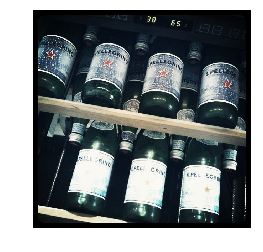

A cooler with several bottles of S. Pellegrino sparkling water.
Bottles of Pellegrino are stacked on refrigerated shelves.
A row of bottles are standing on and behind the shelves.
A box filled with lots of bottles of wine.
The bottles of Pellegrino are all lined up.


In [10]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Step 3: 接下来的任务！

在这个项目中，你要使用图像标注对数据集来训练CNN-RNN模型，从而使其自动由标注生成图像。 在接下来的一个 notebook  (**1_Preliminaries-zh.ipynb**) 中，你将了解更多关于如何设计这种架构的内容。

![Image Captioning CNN-RNN model](https://raw.githubusercontent.com/rawk-v/MLND-projects/master/cv-project1-image-caption/images/encoder-decoder.png)